## setup
https://github.com/yutingng/gen-AC.git

In [ ]:
!git clone https://github.com/yutingng/gen-AC

Cloning into 'gen-AC'...
remote: Enumerating objects: 466, done.
remote: Counting objects: 100% (466/466), done.
remote: Compressing objects: 100% (339/339), done.
remote: Total 466 (delta 159), reused 421 (delta 123), pack-reused 0
Receiving objects: 100% (466/466), 10.28 MiB | 17.84 MiB/s, done.
Resolving deltas: 100% (159/159), done.


In [ ]:
%cd gen-AC

/content/gen-AC


In [ ]:
import os
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

from main import MixExpPhiStochastic, sampleStochastic, Copula
from train import load_data, load_data2

In [ ]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [ ]:
from scipy.stats import bootstrap

## data
https://github.com/yutingng/gen-AC.git

In [ ]:
import pandas as pd
import scipy
import copy

from sklearn.model_selection import train_test_split

In [ ]:
def add_train_random_noise(data, num_adds):
  new_data = np.random.rand(num_adds, data.shape[1])
  return np.concatenate((data, new_data), axis = 0)

In [ ]:
def rank_normalization(X):
  X = copy.deepcopy(X)
  for z in X:
      ndata = z.shape[0]
      gap = 1./(ndata+1)
      nfeats = z.shape[1]
      for i in range(nfeats):
          z[:, i] = scipy.stats.rankdata(z[:, i], 'ordinal')*gap
  return X

In [ ]:
!git clone https://github.com/yutingng/gen-AC.git

Cloning into 'gen-AC'...
remote: Enumerating objects: 466, done.
remote: Counting objects: 100% (466/466), done.
remote: Compressing objects: 100% (339/339), done.
remote: Total 466 (delta 159), reused 421 (delta 123), pack-reused 0
Receiving objects: 100% (466/466), 10.28 MiB | 15.71 MiB/s, done.
Resolving deltas: 100% (159/159), done.


In [ ]:
class Boston():
  def __init__(self):
    # read
    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep = "\s+", skiprows = 22, header = None)
    X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    y = raw_df.values[1::2, 2]

    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, random_state = 142857)
    X_train = np.concatenate((X_train, y_train[:, None]), axis = 1)
    X_test  = np.concatenate((X_test, y_test[:, None]), axis = 1)

    # norm
    [X_train, X_test] = rank_normalization([X_train, X_test])

    # noise
    X_train = add_train_random_noise(X_train, int(X_train.shape[0]*0.01))

    # 2d
    train_data = X_train[:, [0, 13]]
    test_data = X_test[:, [0, 13]]

    # flip
    train_data[:, 0] = 1 - train_data[:, 0]
    test_data[:, 0] = 1 - test_data[:, 0]

    self.train_y = train_data[:, 1].reshape(-1, 1)
    self.train_x = train_data[:, 0].reshape(-1, 1)
    self.validation_y = test_data[:, 1].reshape(-1, 1)
    self.validation_x = test_data[:, 0].reshape(-1, 1)

In [ ]:
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px

from scipy import stats

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
def generate_gaussian(rho, sample_size=2000):
  mean = np.zeros(2)
  E = np.zeros(shape=(2, 2)) + rho
  E[0, 0] = 1
  E[1, 1] =1

  D = np.random.multivariate_normal(mean=mean, cov=E, size=(sample_size, )).T

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D


def GT_gaussian_density(points, rho):
  x = points[0]
  y = points[1]

  c_uv = (1/np.sqrt(1 - rho**2)) * np.exp( ((-1 * rho**2 * x**2 * y**2) - (2*rho*x*y)) / (2*(1 - rho**2)) )
  f_x = stats.norm.pdf(x)
  f_y = stats.norm.pdf(y)

  return c_uv * f_x * f_y

In [ ]:
# Marshal and Olkin
def clayton_sample(theta):
  alpha = 1 / theta
  beta = 1
  V = np.random.gamma(shape=alpha, scale=beta)
  R = np.random.exponential(scale=1, size=2)
  t = R / V
  U = (1 + t) ** (-1/theta)
  return U

# Generate Clayton Copula with N(0,1) margins
def generate_clayton_sample(theta, sample_size=2000):
  X = []
  Y = []
  for _ in range(sample_size):
    U = clayton_sample(theta)
    X.append(stats.norm.ppf(U[0]))
    Y.append(stats.norm.ppf(U[1]))

  D = np.concatenate((X, Y)).reshape((2, -1))

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D

In [ ]:
# Marshal and Olkin
def frank_sample(theta):
  p = 1 - np.exp(-theta)
  V = stats.logser.rvs(p)
  R = np.random.exponential(scale=1, size=2)
  t = R / V
  U = -1/theta * np.log( 1 - ( (1 - np.exp(-theta)) * (np.exp(-t)) ) )
  return U

# Generate Frank Copula with N(0,1) margins
def generate_frank_sample(theta, sample_size=2000):
  X = []
  Y = []
  for _ in range(sample_size):
    U = frank_sample(theta)
    X.append(stats.norm.ppf(U[0]))
    Y.append(stats.norm.ppf(U[1]))

  D = np.concatenate((X, Y)).reshape((2, -1))

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D

In [ ]:
def visualize_data(D):
  _, ax = plt.subplots(figsize=(5.5, 5))

  ax.scatter(
      D[0],
      D[1],
      s=80,
      edgecolor='k',
      alpha=0.5
  )

  plt.show()

## param

In [ ]:
optim_args = \
{
    'lr': 1e-5, # it is 1e-3 since torch.sum was used instead of torch.mean for loglikelihood
    'momentum': 0.9
}

num_epochs = 6000
batch_size = 200
chkpt_freq = 500

identifier = 'None'

In [ ]:
def expt(train_data, test_data,
         net,
         optimizer,
         optim_args,
         identifier,
         num_epochs=1000,
         batch_size=100,
         chkpt_freq=50,
         ):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=1000000, shuffle=True)

    train_loss_per_epoch = []

    for epoch in range(num_epochs):
        loss_per_minibatch = []
        for i, data in enumerate(train_loader, 0):
            optimizer.zero_grad()

            net.phi.resample_M(100)

            d = data.detach().clone()
            p = net(d, mode='pdf2')

            scaleloss = torch.square(torch.mean(net.phi.M)-1)
            logloss = -torch.sum(torch.log(p))
            reg_loss = logloss+scaleloss
            reg_loss.backward()

            loss_per_minibatch.append((logloss/p.numel()).detach().numpy())
            optimizer.step()

        train_loss_per_epoch.append(np.mean(loss_per_minibatch))
        if True:
            net.phi.resample_M(1000)

            samples = sampleStochastic(net, 2, 1000).detach()
            # plt.scatter(samples[:, 0], samples[:, 1])
            # plt.axis("square")
            # plt.clf()

        for i, data in enumerate(test_loader, 0):
            net.zero_grad()
            net.phi.resample_M(1000)
            d = data.detach().clone()
            p = net(d, mode='pdf2')
            logloss = -torch.mean(torch.log(p))

        print('Epoch %s: Train %s, Val %s' %
          (epoch, train_loss_per_epoch[-1], logloss.item()))
    return p

## boston

In [ ]:
phi = MixExpPhiStochastic()
net = Copula(phi)
optimizer = optim.SGD(net.parameters(), optim_args['lr'], optim_args['momentum'])

In [ ]:
data_loader = Boston()
train_D = np.array([data_loader.train_x, data_loader.train_y])[:, :, 0]
test_D = np.array([data_loader.validation_x, data_loader.validation_y])[:, :, 0]

In [ ]:
train_D.shape

(2, 382)

In [ ]:
train_data = torch.tensor(train_D).requires_grad_(True).T
test_data = torch.tensor(test_D).requires_grad_(True).T

In [ ]:
train_data.shape

torch.Size([382, 2])

In [ ]:
yhat = expt(train_data, test_data, net, optimizer, optim_args, identifier, num_epochs, batch_size, chkpt_freq)

Streaming output truncated to the last 5000 lines.
Epoch 5000: Train -0.25090145846708967, Val -0.28549457183520555
Epoch 5001: Train -0.26837266172981833, Val -0.2855501917852139
Epoch 5002: Train -0.2676511240971667, Val -0.2836593769066868
Epoch 5003: Train -0.2476343624651166, Val -0.2838649179652852
Epoch 5004: Train -0.2621573450341501, Val -0.2857474432825462
Epoch 5005: Train -0.2463408655386692, Val -0.28782887005815216
Epoch 5006: Train -0.26428187034917416, Val -0.2907016252501981
Epoch 5007: Train -0.25914812167248935, Val -0.28326478574392777
Epoch 5008: Train -0.24425022480938793, Val -0.2854976476589975
Epoch 5009: Train -0.2663496598099066, Val -0.28687252789379103
Epoch 5010: Train -0.25847571684983217, Val -0.28388610671047354
Epoch 5011: Train -0.2668005485120485, Val -0.2857709116392192
Epoch 5012: Train -0.2628615411206889, Val -0.2880979708855997
Epoch 5013: Train -0.25954300400812513, Val -0.28480846128877324
Epoch 5014: Train -0.26087883143209206, Val -0.2860989

In [ ]:
yhat = -np.log(yhat.detach().numpy())

In [ ]:
nll = np.mean(yhat)
nll

-0.28892763168125907

In [ ]:
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.4f}$\pm${dev:.4f}')

NLL: -0.2889 RMean: -0.2889 IC: (-0.3963,-0.1802) Notation: -0.2889$\pm$0.1086


## Gauss $\rho = 0.1$

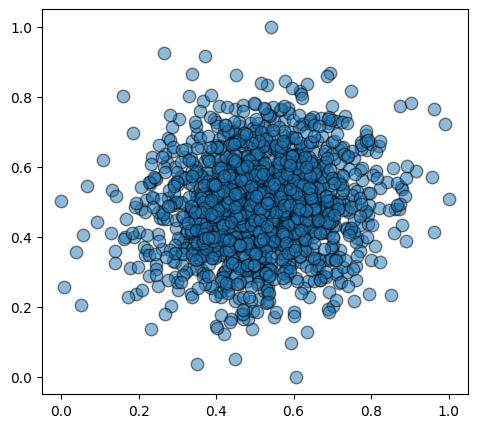

In [ ]:
np.random.seed(30091985)

phi = MixExpPhiStochastic()
net = Copula(phi)
optimizer = optim.SGD(net.parameters(), optim_args['lr'], optim_args['momentum'])

rho = 0.1
train_D, test_D = generate_gaussian(rho)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
train_data = torch.tensor(train_D).requires_grad_(True).T
test_data = torch.tensor(test_D).requires_grad_(True).T

yhat = expt(train_data, test_data, net, optimizer, optim_args, identifier, num_epochs, batch_size, chkpt_freq)

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 1000: Train -6.153728260862165e-05, Val -5.2908154609304094e-05
Epoch 1001: Train -6.177859009218328e-05, Val -5.358278499148092e-05
Epoch 1002: Train -6.40606222399571e-05, Val -5.201726143530297e-05
Epoch 1003: Train -6.037674821947137e-05, Val -5.118115336851017e-05
Epoch 1004: Train -6.264576117575446e-05, Val -5.584641263612099e-05
Epoch 1005: Train -6.412980221919981e-05, Val -5.556660257555335e-05
Epoch 1006: Train -6.472189270283298e-05, Val -5.2902299411924056e-05
Epoch 1007: Train -6.418880346924703e-05, Val -5.512123927526202e-05
Epoch 1008: Train -6.216675081622137e-05, Val -5.5455268871121836e-05
Epoch 1009: Train -6.36642096530639e-05, Val -5.3613239830482605e-05
Epoch 1010: Train -5.459927419095951e-05, Val -5.372925737695192e-05
Epoch 1011: Train -6.484231403401933e-05, Val -5.4467078784462744e-05
Epoch 1012: Train -6.356624215051395e-05, Val -5.51550900831853e-05
Epoch 1013: Train -6.0343070090908854e-05,

In [ ]:
yhat = -np.log(yhat.detach().numpy())
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.4f}$\pm${dev:.4f}')

NLL: -0.0643 RMean: -0.0643 IC: (-0.1398,0.0216) Notation: -0.0643$\pm$0.0859


## Gauss $\rho = 0.5$

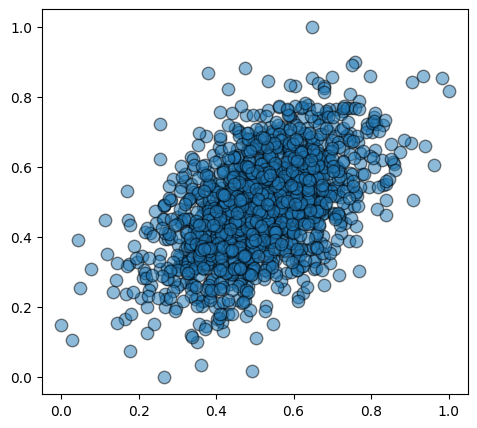

In [ ]:
np.random.seed(30091985)

phi = MixExpPhiStochastic()
net = Copula(phi)
optimizer = optim.SGD(net.parameters(), optim_args['lr'], optim_args['momentum'])

rho = 0.5
train_D, test_D = generate_gaussian(rho)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
train_data = torch.tensor(train_D).requires_grad_(True).T
test_data = torch.tensor(test_D).requires_grad_(True).T

yhat = expt(train_data, test_data, net, optimizer, optim_args, identifier, num_epochs, batch_size, chkpt_freq)

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 1000: Train -0.4860112543091899, Val -0.32787792825315853
Epoch 1001: Train -0.5025947928503172, Val -0.3121429801135191
Epoch 1002: Train -0.48106417909816857, Val -0.33671317622353647
Epoch 1003: Train -0.49688564465045115, Val -0.32347209953809364
Epoch 1004: Train -0.494101325015421, Val -0.30706962444217917
Epoch 1005: Train -0.5004933277021679, Val -0.3277109833567217
Epoch 1006: Train -0.5041638734838366, Val -0.31466174178401873
Epoch 1007: Train -0.4925797758258179, Val -0.30975800490048055
Epoch 1008: Train -0.48518902265786423, Val -0.3193900769855961
Epoch 1009: Train -0.5019672871596622, Val -0.31836170810397924
Epoch 1010: Train -0.4942178739308603, Val -0.32127256857913605
Epoch 1011: Train -0.5074381542018013, Val -0.33283096863209416
Epoch 1012: Train -0.4879079735048023, Val -0.3088176015292997
Epoch 1013: Train -0.5007151036313846, Val -0.30329495114616983
Epoch 1014: Train -0.5074495093101465, Val -0.3

In [ ]:
yhat = -np.log(yhat.detach().numpy())
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.4f}$\pm${dev:.4f}')

NLL: -0.2946 RMean: -0.2940 IC: (-0.3693,-0.2073) Notation: -0.2940$\pm$0.0867


## Gauss $\rho = 0.9$

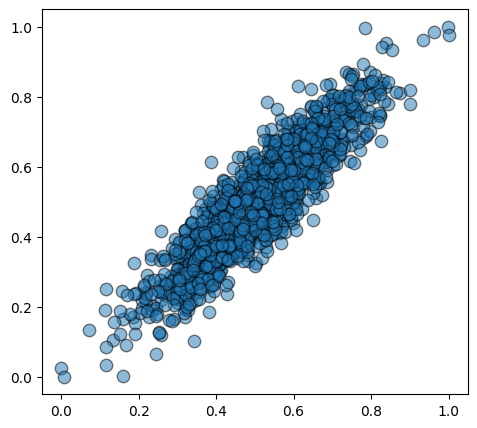

In [ ]:
np.random.seed(30091985)

phi = MixExpPhiStochastic()
net = Copula(phi)
optimizer = optim.SGD(net.parameters(), optim_args['lr'], optim_args['momentum'])

rho = 0.9
train_D, test_D = generate_gaussian(rho)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
train_data = torch.tensor(train_D).requires_grad_(True).T
test_data = torch.tensor(test_D).requires_grad_(True).T

yhat = expt(train_data, test_data, net, optimizer, optim_args, identifier, num_epochs, batch_size, chkpt_freq)

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 1000: Train -0.06229270330859831, Val -0.07637131383998684
Epoch 1001: Train -0.0636523982567822, Val -0.08156581986467572
Epoch 1002: Train -0.06958793230850868, Val -0.08646707424665567
Epoch 1003: Train -0.06997114315626671, Val -0.09051394739794777
Epoch 1004: Train -0.07367082015297066, Val -0.09240276954897485
Epoch 1005: Train -0.07891348196200026, Val -0.09643312782533203
Epoch 1006: Train -0.07415729087772664, Val -0.09989757905191811
Epoch 1007: Train -0.08733545796660422, Val -0.10350338565673568
Epoch 1008: Train -0.0831790092991308, Val -0.10211477501055828
Epoch 1009: Train -0.08920596421521304, Val -0.11479261158011303
Epoch 1010: Train -0.09711998145354146, Val -0.11843619528035779
Epoch 1011: Train -0.1020790487516514, Val -0.12413929955681258
Epoch 1012: Train -0.1034012742559157, Val -0.13185065947807945
Epoch 1013: Train -0.11703161832157967, Val -0.12752706454471163
Epoch 1014: Train -0.11218629638585

In [ ]:
yhat = -np.log(yhat.detach().numpy())
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.4f}$\pm${dev:.4f}')

NLL: -1.0764 RMean: -1.0757 IC: (-1.1495,-0.9951) Notation: -1.0757$\pm$0.0806


## Clayton $\theta = 1$

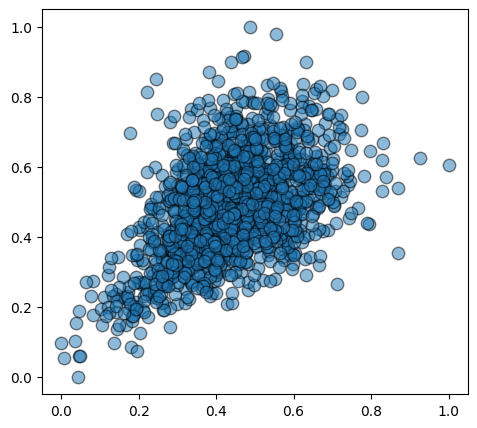

In [ ]:
np.random.seed(30091985)

phi = MixExpPhiStochastic()
net = Copula(phi)
optimizer = optim.SGD(net.parameters(), optim_args['lr'], optim_args['momentum'])

theta = 1
train_D, test_D = generate_clayton_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
train_data = torch.tensor(train_D).requires_grad_(True).T
test_data = torch.tensor(test_D).requires_grad_(True).T

yhat = expt(train_data, test_data, net, optimizer, optim_args, identifier, num_epochs, batch_size, chkpt_freq)

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 1000: Train -0.5059454804277669, Val -0.5161956729279745
Epoch 1001: Train -0.5194177401664299, Val -0.5020822207285432
Epoch 1002: Train -0.49616438300188537, Val -0.511628398068574
Epoch 1003: Train -0.49318234880650813, Val -0.5043481079110506
Epoch 1004: Train -0.5099380264761808, Val -0.502675102971886
Epoch 1005: Train -0.49434790959265784, Val -0.5057701284308764
Epoch 1006: Train -0.5062859984757699, Val -0.4990163932770888
Epoch 1007: Train -0.4792200426477056, Val -0.49749397602062123
Epoch 1008: Train -0.5041072141757472, Val -0.4962638250530605
Epoch 1009: Train -0.5070327356819377, Val -0.5084478899958376
Epoch 1010: Train -0.4875494119734812, Val -0.4888917273286548
Epoch 1011: Train -0.5050123539741718, Val -0.5023988402903591
Epoch 1012: Train -0.4993034776634154, Val -0.5024599870373114
Epoch 1013: Train -0.5051599569325047, Val -0.4953452768670171
Epoch 1014: Train -0.4916952972912445, Val -0.50619084938

In [ ]:
yhat = -np.log(yhat.detach().numpy())
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.4f}$\pm${dev:.4f}')

NLL: -0.5250 RMean: -0.5245 IC: (-0.5864,-0.4609) Notation: -0.5245$\pm$0.0636


## Clayton $\theta = 5$

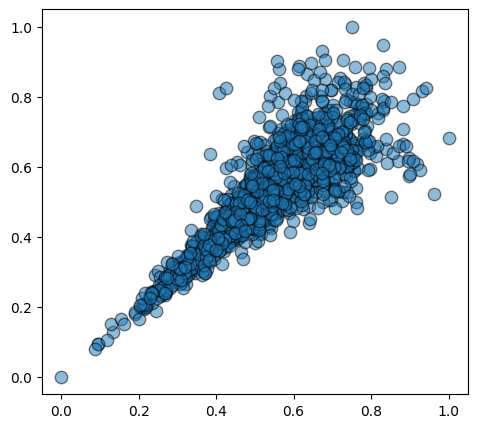

In [ ]:
np.random.seed(30091985)

phi = MixExpPhiStochastic()
net = Copula(phi)
optimizer = optim.SGD(net.parameters(), optim_args['lr'], optim_args['momentum'])

theta = 5
train_D, test_D = generate_clayton_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
train_data = torch.tensor(train_D).requires_grad_(True).T
test_data = torch.tensor(test_D).requires_grad_(True).T

yhat = expt(train_data, test_data, net, optimizer, optim_args, identifier, num_epochs, batch_size, chkpt_freq)

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 1000: Train -1.2586511623443357, Val -0.9432572348564817
Epoch 1001: Train -1.2100868615977594, Val -0.9754463866593088
Epoch 1002: Train -1.2410695218381105, Val -0.9742464017711597
Epoch 1003: Train -1.2655726507266158, Val -0.9285801832747264
Epoch 1004: Train -1.2052792178561165, Val -0.9749590523660522
Epoch 1005: Train -1.2588169506707598, Val -0.9858478796393813
Epoch 1006: Train -1.2435307340271027, Val -0.9752435481505417
Epoch 1007: Train -1.2030801121559387, Val -0.9481307970745162
Epoch 1008: Train -1.2493569738759964, Val -1.020476637374281
Epoch 1009: Train -1.2842292539831677, Val -0.9628167012041117
Epoch 1010: Train -1.217370247854324, Val -0.952095866835101
Epoch 1011: Train -1.2356475208612157, Val -0.9566685782161339
Epoch 1012: Train -1.2517966049001927, Val -0.9516409061136749
Epoch 1013: Train -1.2515218972447153, Val -0.9989019803030535
Epoch 1014: Train -1.2259127959146974, Val -0.9516623593418847

In [ ]:
yhat = -np.log(yhat.detach().numpy())
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.4f}$\pm${dev:.4f}')

NLL: -0.9368 RMean: -0.9354 IC: (-1.0540,-0.8084) Notation: -0.9354$\pm$0.1270


## Clayton $\theta = 10$

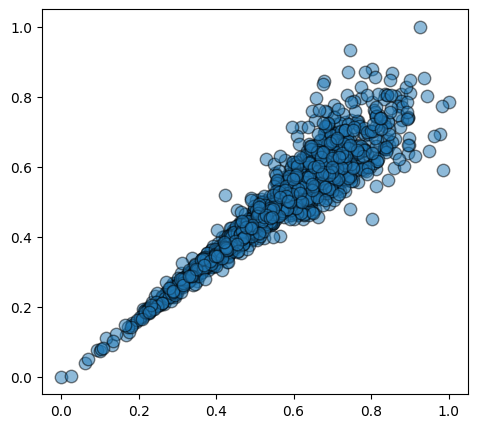

In [ ]:
np.random.seed(30091985)

phi = MixExpPhiStochastic()
net = Copula(phi)
optimizer = optim.SGD(net.parameters(), optim_args['lr'], optim_args['momentum'])

theta = 10
train_D, test_D = generate_clayton_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
train_data = torch.tensor(train_D).requires_grad_(True).T
test_data = torch.tensor(test_D).requires_grad_(True).T

yhat = expt(train_data, test_data, net, optimizer, optim_args, identifier, num_epochs, batch_size, chkpt_freq)

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 1000: Train -9.771672763145801e-06, Val -1.2631349962953451e-05
Epoch 1001: Train -8.816888506512134e-06, Val -1.278432846076817e-05
Epoch 1002: Train -9.508391573571532e-06, Val -1.2009867346840418e-05
Epoch 1003: Train -9.338275170121772e-06, Val -1.1424409511638966e-05
Epoch 1004: Train -9.390133140797178e-06, Val -1.252693387458491e-05
Epoch 1005: Train -9.865784889823333e-06, Val -1.1729428881242932e-05
Epoch 1006: Train -9.868473041425491e-06, Val -1.1954202101018529e-05
Epoch 1007: Train -1.0514442530689762e-05, Val -1.2307013535495644e-05
Epoch 1008: Train -8.132965782323387e-06, Val -1.272541892043827e-05
Epoch 1009: Train -8.926504907921076e-06, Val -1.1940235629621948e-05
Epoch 1010: Train -1.069732141225365e-05, Val -1.2039060560327003e-05
Epoch 1011: Train -9.350189444654005e-06, Val -1.2561501460410147e-05
Epoch 1012: Train -9.578634435308819e-06, Val -1.2490330481484893e-05
Epoch 1013: Train -9.556581051302

In [ ]:
yhat = -np.log(yhat.detach().numpy())
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.4f}$\pm${dev:.4f}')

NLL: -1.4049 RMean: -1.4049 IC: (-1.4534,-1.3539) Notation: -1.4049$\pm$0.0510


## Frank $\theta = 1$

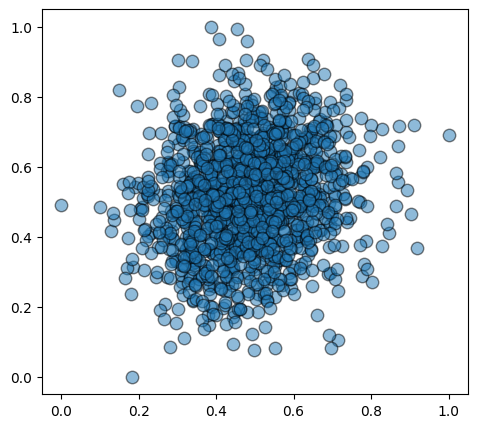

In [ ]:
np.random.seed(30091985)

phi = MixExpPhiStochastic()
net = Copula(phi)
optimizer = optim.SGD(net.parameters(), optim_args['lr'], optim_args['momentum'])

theta = 1
train_D, test_D = generate_frank_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
train_data = torch.tensor(train_D).requires_grad_(True).T
test_data = torch.tensor(test_D).requires_grad_(True).T

yhat = expt(train_data, test_data, net, optimizer, optim_args, identifier, num_epochs, batch_size, chkpt_freq)

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 1000: Train -0.006276700336604574, Val -0.002673149720195681
Epoch 1001: Train -0.005757410271196444, Val -0.002739096755509047
Epoch 1002: Train -0.0063505272997135525, Val -0.0026269769079692758
Epoch 1003: Train -0.005926089424309073, Val -0.0029562597797202534
Epoch 1004: Train -0.006531591605940634, Val -0.0028902905146510924
Epoch 1005: Train -0.006503039661847079, Val -0.0027985074998760147
Epoch 1006: Train -0.006131770450807948, Val -0.0029445230773624902
Epoch 1007: Train -0.006409562087033775, Val -0.0028187289990303887
Epoch 1008: Train -0.0061564827866685615, Val -0.0028323445075421312
Epoch 1009: Train -0.0067818627079700815, Val -0.002952479258689856
Epoch 1010: Train -0.006218843741493318, Val -0.0028757453582302123
Epoch 1011: Train -0.006865600900019925, Val -0.0030703946263587324
Epoch 1012: Train -0.006692446684458396, Val -0.0029910337622716435
Epoch 1013: Train -0.006580833142486793, Val -0.002846538

In [ ]:
yhat = -np.log(yhat.detach().numpy())
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.4f}$\pm${dev:.4f}')

NLL: -0.1529 RMean: -0.1530 IC: (-0.2125,-0.0808) Notation: -0.1530$\pm$0.0722


## Frank $\theta = 5$

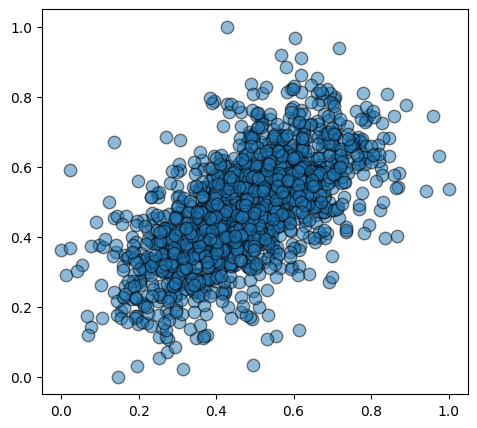

In [ ]:
np.random.seed(30091985)

phi = MixExpPhiStochastic()
net = Copula(phi)
optimizer = optim.SGD(net.parameters(), optim_args['lr'], optim_args['momentum'])

theta = 5
train_D, test_D = generate_frank_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
train_data = torch.tensor(train_D).requires_grad_(True).T
test_data = torch.tensor(test_D).requires_grad_(True).T

yhat = expt(train_data, test_data, net, optimizer, optim_args, identifier, num_epochs, batch_size, chkpt_freq)

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 1000: Train -0.5602958952708885, Val -0.487415455919903
Epoch 1001: Train -0.5660735008937843, Val -0.48831406203514865
Epoch 1002: Train -0.5759024046100206, Val -0.4842393498328225
Epoch 1003: Train -0.5563500318089112, Val -0.49347955846825337
Epoch 1004: Train -0.5679462460068861, Val -0.48569130885362416
Epoch 1005: Train -0.5832997766212444, Val -0.48239492253894845
Epoch 1006: Train -0.5703184498280776, Val -0.48334041321164806
Epoch 1007: Train -0.5663433249388046, Val -0.48137706929062296
Epoch 1008: Train -0.5737013285757597, Val -0.48188472191537307
Epoch 1009: Train -0.5640298881933588, Val -0.4880567917753072
Epoch 1010: Train -0.5612323424646122, Val -0.48704278663501704
Epoch 1011: Train -0.5657768652840058, Val -0.48273538337572175
Epoch 1012: Train -0.5774480027734183, Val -0.48145479203180197
Epoch 1013: Train -0.5617847732488956, Val -0.49362322390134966
Epoch 1014: Train -0.553949569939068, Val -0.4963

In [ ]:
yhat = -np.log(yhat.detach().numpy())
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.4f}$\pm${dev:.4f}')

NLL: -0.4948 RMean: -0.4948 IC: (-0.5651,-0.4143) Notation: -0.4948$\pm$0.0805


## Frank $\theta = 10$

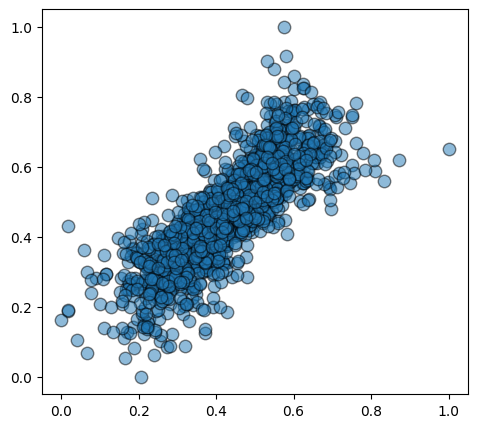

In [ ]:
np.random.seed(30091985)

phi = MixExpPhiStochastic()
net = Copula(phi)
optimizer = optim.SGD(net.parameters(), optim_args['lr'], optim_args['momentum'])

theta = 10
train_D, test_D = generate_frank_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
train_data = torch.tensor(train_D).requires_grad_(True).T
test_data = torch.tensor(test_D).requires_grad_(True).T

yhat = expt(train_data, test_data, net, optimizer, optim_args, identifier, num_epochs, batch_size, chkpt_freq)

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 1000: Train -0.00018142199437821158, Val -0.00026073685258226045
Epoch 1001: Train -0.0001867577640557834, Val -0.0002498812210321025
Epoch 1002: Train -0.0001801120317244834, Val -0.00026796517824018607
Epoch 1003: Train -0.00019770096784879631, Val -0.0002589046048782115
Epoch 1004: Train -0.000177616568875777, Val -0.0002705072265339973
Epoch 1005: Train -0.00017919593692786135, Val -0.00025609537818614074
Epoch 1006: Train -0.0001880974197347325, Val -0.0002694765175363687
Epoch 1007: Train -0.00018477806297669623, Val -0.0002555953769817808
Epoch 1008: Train -0.0001949588151684968, Val -0.00026127581194262
Epoch 1009: Train -0.00017961505611957155, Val -0.00026717992250384993
Epoch 1010: Train -0.00019468169544054889, Val -0.000264299052770958
Epoch 1011: Train -0.00019305139382131537, Val -0.00026960928018078143
Epoch 1012: Train -0.00020170303861748634, Val -0.00025707582990019463
Epoch 1013: Train -0.0001882051042

In [ ]:
yhat = -np.log(yhat.detach().numpy())
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.4f}$\pm${dev:.4f}')

NLL: -0.5666 RMean: -0.5669 IC: (-0.6602,-0.4612) Notation: -0.5669$\pm$0.1057
